In [9]:
import pandas as pd
import numpy as np
import xgboost as xgb
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# graphing settings
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

# Limpieza de datos

In [10]:
df = pd.read_csv('../datasets/rava-dolar-mep-historico.csv')
df = df.set_index('fecha')
df.index = pd.to_datetime(df.index)

def setTimeFeatures(df):
    df = df.copy()
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter # quarter of year
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = setTimeFeatures(df)

for col in ['especie', 'hora', 'ultimo', 'apertura', 
            'varMTD', 'varYTD', 'var6M', 'var12M',
            'variacion',
            'volumen']:
    df = df.drop(col, axis=1)


## Armado del dataset

In [11]:
features = [
    'anterior',
    'timestamp', 'dayofweek', 'quarter', 'month', 'year',
    'dayofyear', 'dayofmonth', 'weekofyear']
target = 'cierre'

df = df[df.index > '11-15-2021']
X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Entrenamiento modelo

In [12]:
reg = xgb.XGBRegressor(
        three_method='hist', # metodo           
        booster='gbtree', # metodo
        n_estimators=5000, # numero de arboles
        early_stopping_rounds=50, # detiene el entrenamiento si no mejora
        max_depth=3, # maxima profundidad de los arboles --> overfitting
        learning_rate=0.005)

reg.fit(X_train,
        y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)], # cross-validation metrics
        verbose=1000)

[0]	validation_0-rmse:285.02254	validation_1-rmse:290.86329


c:\Users\sebas\Proyectos\BotFinanciero\.venv\lib\site-packages\xgboost\core.py:160: UserWarning: [20:50:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "three_method" } are not used.

  warnings.warn(smsg, UserWarning)


[1000]	validation_0-rmse:7.42379	validation_1-rmse:12.19366
[1519]	validation_0-rmse:5.81587	validation_1-rmse:11.51909


XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.005, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=5000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## Evaluaciones

In [18]:
mean_squared_error(df['cierre'], df['prediction'])

54.24222769802482

## Simulaciones

In [13]:
def simulateDays(df, reg, days=1):
    """
    Agrega al df la cantidad de dias que se le pase por parametro
    a partir del ultimo dia del df.
   
    """
    d = 0
    
    last_day_input = df.tail(1).iloc[0]
    last_value = last_day_input['cierre']
    last_date = dt.datetime.fromtimestamp(last_day_input['timestamp'])
    next_date = last_date + dt.timedelta(days=1)
    
    mdf = df.tail(1).copy()

    while d < days:
        curr_day_features = {
            "anterior": last_value,
            "timestamp": last_day_input['timestamp'] + 86400,
            "dayofweek": next_date.weekday(),
            "quarter": pd.Timestamp(next_date).quarter,
            "month": next_date.month,
            "year": next_date.year,
            "dayofyear": next_date.timetuple().tm_yday,
            "dayofmonth": next_date.day,
            "weekofyear": next_date.isocalendar().week,
        }

        curr_day_target = reg.predict(pd.DataFrame(curr_day_features, index=[0]))[0]
        curr_day_features['prediction'] = curr_day_target 
        last_value = curr_day_target

        mdf.loc[next_date] = curr_day_features
        
        next_date = next_date + dt.timedelta(days=1)
        last_day_input = curr_day_features
        d+=1

    return mdf

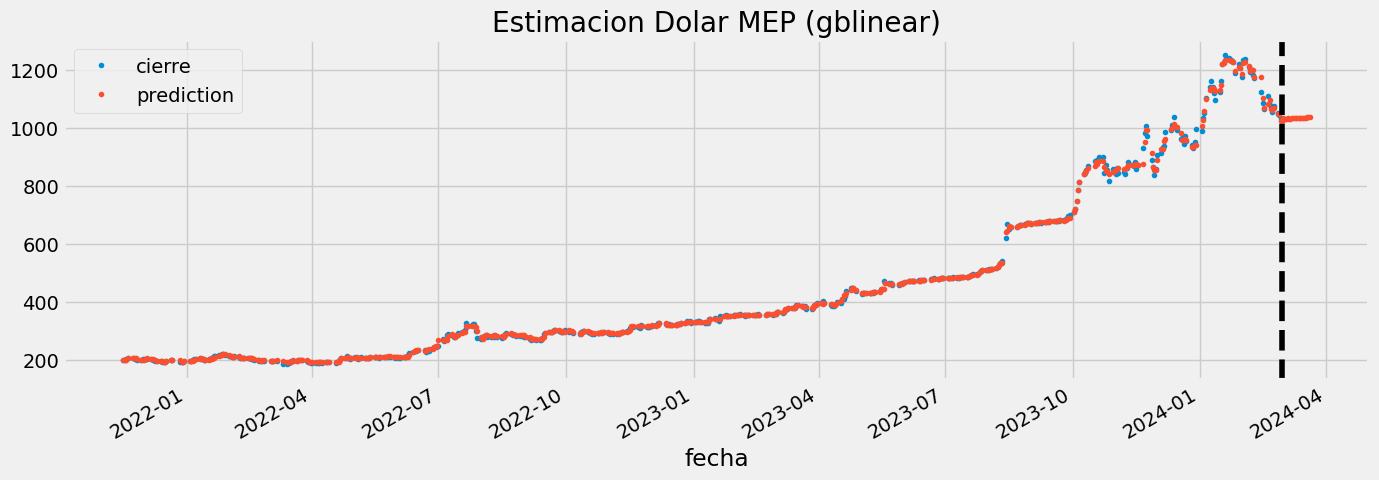

In [14]:
fig, ax = plt.subplots(figsize=(15, 5))

df['prediction'] = reg.predict(df[features])
preds = simulateDays(df, reg, 20)
df_concat = pd.concat([df, preds])

df_concat.loc[df_concat.index > '11-01-2021', ['cierre', 'prediction']] \
         .plot(ax=ax, title='Estimacion Dolar MEP (gblinear)', color=color_pal, style='.')

last_day_input = df.tail(1).iloc[0]
last_date = dt.datetime.fromtimestamp(last_day_input['timestamp'])
next_date = last_date + dt.timedelta(days=1)
ax.axvline(last_date, color='black', ls='--') 

plt.show()

In [15]:
preds.head(2)

,anterior,minimo,maximo,cierre,timestamp,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,prediction
fecha,,,,,,,,,,,,,
2024-02-29,1031.25,1026.16,1046.08,1028.94,1.709176e+09,3,1,2,2024,60,29,9,1022.526550
2024-03-01,1028.94,NaN,NaN,NaN,1.709262e+09,4,1,3,2024,61,1,9,1034.040405


### Save model

In [22]:
today = dt.datetime.now().strftime("%m-%d-%Y-%H-%M-%S")
score = round(mean_squared_error(df['cierre'], df['prediction']), 2)

reg.save_model(f'../trained/xgb_time_series/xgb-model_{today}_{score}.json')

In [25]:
# load model
q = xgb.XGBRegressor()
q.load_model('../trained/xgb_time_series/xgb-model_02-29-2024-21-02-29_54.24.json')

XGBRegressor(base_score='4.615108E2', booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             feature_types=['float', 'int', 'int', 'int', 'int', 'int', 'int',
                            'int', 'i'],
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)